In [1]:
import os
# import math
from itertools import repeat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)  # if you need to view less rows, comment
# pd.set_option('display.max_rows', None)  # if you need to view more rows, uncomment
mean = 'mean'
std = 'std'
idx_slice = pd.IndexSlice

In [72]:
file_location = '/home/kmeador/SEC' # escher
# file_location = '/home/kylemeador' # powerpanda
file_name = '211008_10E_SEC_Superdex200'
extension = 'csv'
analysis_file = os.path.join(file_location, '%s.%s' % (file_name, extension))

## Check DataFrame columns and values

### for datasets that are exported with volumes for every measurement

In [107]:
sec_data_df = pd.read_csv(analysis_file, header=[0,1])

### For datasets that are exported with normalized volumes (every measurement is indexed to the same volume)

In [107]:
sec_data_df = pd.read_csv(analysis_file, header=[0,1], index_col=0)

In [107]:
sec_data_df.head()

10E Run01                                                          \
  UV3 (280 nm)_volume UV3 (280 nm)_mAU Conductivity_volume Conductivity_mS/cm   
0           -0.993075              0.0           -0.993075           6.052461   
1           -0.990585              0.0           -0.990585           6.052461   
2           -0.988681              0.0           -0.988681           6.052692   
3           -0.986777              NaN           -0.986777           6.052461   
4           -0.984384              NaN           -0.984384           6.052461   

                                                                     \
  %B_volume   %B_% delta Col Pressure_volume delta Col Pressure_MPa   
0 -0.993075  100.0                 -0.987753               0.013790   
1 -0.989755  100.0                 -0.978574               0.000000   
2 -0.980966  100.0                 -0.966269               0.068948   
3 -0.968759  100.0                 -0.953769               0.275790   
4 -0.956259  100.0                 -0.941269               0.427475   

                                                                    \
  Temperature_volume Temperature_C Baseline of UV3 (280 nm)_volume   
0          -0.993075     11.217049                       -0.993075   
1          -0.990585     11.217049                       -0.990585   
2          -0.988681     11.217049                       -0.988681   
3          -0.986777     11.217049                       -0.986777   
4          -0.984384     11.217049                       -0.984384   

                                
  Baseline of UV3 (280 nm)_mAU  
0                  -326.484680  
1                  -326.438040  
2                  -326.402336  
3                          NaN  
4                          NaN

In [106]:
def split_biorad_chromatogram_dataframe_to_unique_runs(df):
    split_dfs = []
    for run in df.columns.levels[0].to_list():
        split_dfs.append(df.loc[:, idx_slice[run, :]])
    
    return split_dfs

In [96]:
def extract_volume_and_uv_columns_from_biorad_chromatogram(df):
    uv_columns = []
    volume = None
    for column in df.columns.levels[-1].to_list():
        if column.startswith('UV'):
            if column.endswith('_volume'):  # not volume and 
                volume = column
            else:
                uv_columns.append(column)
    return volume, uv_columns

In [97]:
sec_runs = split_biorad_chromatogram_dataframe_to_unique_runs(sec_data_df)
chromatogram_graph_data = [extract_volume_and_uv_columns_from_biorad_chromatogram(run_df) for run_df in sec_runs]

In [100]:
volume, uv_columns = chromatogram_graph_data[0]
print(volume, uv_columns)

UV3 (280 nm)_volume ['UV3 (280 nm)_mAU']


In [23]:
vol_idx, uv_idx = 0, 1
for idx, run_df in enumerate(sec_runs):
    volume, uv_columns = chromatogram_graph_data[idx][vol_idx], chromatogram_graph_data[idx][uv_idx]
    formatted_df = run_df.loc[:, idx_slice[:, [volume] + uv_columns]].droplevel(0, axis=1)
    # grab first level, first (and only index)
    # df_title = run_df.columns.levels[0].unique()  # Doesn't work as grabs old levels from original DF
    df_title = run_df.columns.get_level_values(0).unique()
    if len(df_title) != 1:
        print('Error, multiple headers detected in dataframe %s!\n%s' % (df_title, run_df.head()))
        break
    # formatted_df = formatted_df[formatted_df[volume] > 0.007]
    # format the volume as the dependent variable
    formatted_df.index = formatted_df[volume]
    formatted_df.index.name = 'Volume'
    formatted_df.drop(volume, axis=1, inplace=True)
    # format column names to be pretty
    formatted_df.columns = formatted_df.columns.map(dict(zip(formatted_df.columns, 
        map(str.strip, 
            map(str.strip, 
                map(str.replace, 
                    map(str.replace, formatted_df.columns, repeat('_mAU'), repeat('')),
                    repeat('UV'), repeat('')), 
                repeat('1234567890 ')), 
            repeat('()')))))
    formatted_df.plot()

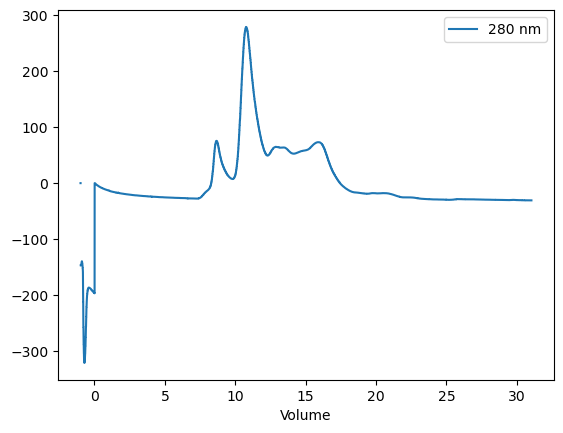

In [104]:
plt.show()

In [94]:
#formatted_df

In [91]:
formatted_df['280 nm'].plot()

<AxesSubplot:xlabel='volume'>

In [92]:
formatted_df.plot()

<AxesSubplot:xlabel='volume'>

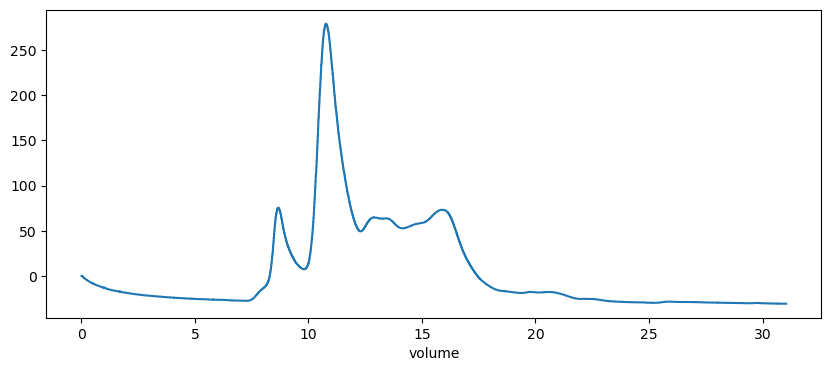

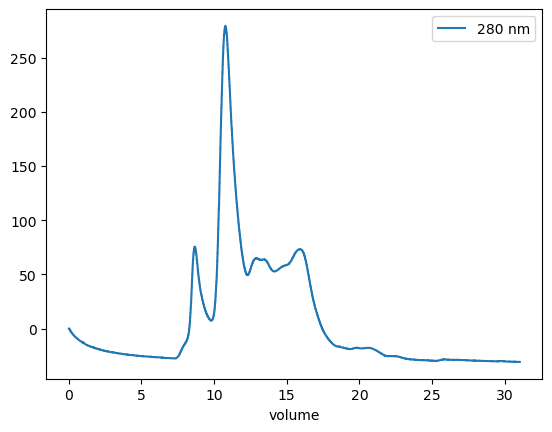

In [93]:
plt.show()

In [85]:
figure_aspect_ratio = (10, 4)
fig = plt.figure(figsize=figure_aspect_ratio)
uv_ax = fig.subplots(1, 1)
uv_ax.plot(formatted_df, ) # label='Contact Order', color='#fbc0cb', lw=1, linestyle='-'

In [86]:
fig.clear()